In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

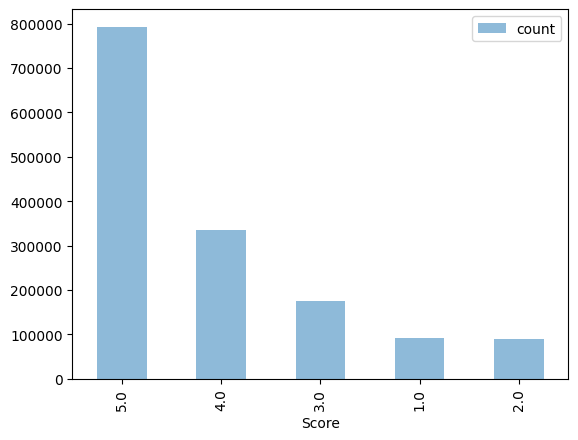


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [12]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the Files
trainingSet = pd.read_csv("/content/drive/MyDrive/cs506midterm/train.csv")
testingSet = pd.read_csv("/content/drive/MyDrive/cs506midterm/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print("\nEVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features
def add_features_to(df):
    # Basic feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Review length
    if 'Text' in df.columns:
        df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x)))
        df['WordCount'] = df['Text'].apply(lambda x: len(str(x).split()))

        # Sentiment analysis (polarity and subjectivity)
        df['SentimentPolarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        df['SentimentSubjectivity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    return df

# Load the feature extracted files if they've already been generated
if exists('/content/drive/MyDrive/cs506midterm/X_train.csv'):
    X_train = pd.read_csv("/content/drive/MyDrive/cs506midterm/X_train.csv")
    X_submission = pd.read_csv("/content/drive/MyDrive/cs506midterm/X_submission.csv")
else:
    # Process the DataFrame with sampling to reduce memory usage
    train = trainingSet.sample(frac=0.05, random_state=42)  # Use 5% of the data for processing to reduce runtime
    train = add_features_to(train)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    # Save the processed data for future use
    X_submission.to_csv("/content/drive/MyDrive/cs506midterm/X_submission.csv", index=False)
    X_train.to_csv("/content/drive/MyDrive/cs506midterm/X_train.csv", index=False)

# Store the target variable 'Score' before transformations
Y_train = X_train['Score']
Y_submission = X_submission['Score']

# Drop 'Score' column from features
X_train = X_train.drop(columns=['Score'])
X_submission = X_submission.drop(columns=['Score'])

# Sample and Split into Training and Testing Set

# Apply TF-IDF and Latent Semantic Analysis (LSA) to the text column
if 'Text' in X_train.columns:
    tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')  # Reduce max_features to 500 to save time
    X_train_text_tfidf = tfidf_vectorizer.fit_transform(X_train['Text'].fillna(''))
    X_submission_text_tfidf = tfidf_vectorizer.transform(X_submission['Text'].fillna(''))

    # Apply LSA (using TruncatedSVD) to reduce dimensionality
    lsa = TruncatedSVD(n_components=50, random_state=42)  # Reduce n_components to 50 to save time
    X_train_text_lsa = lsa.fit_transform(X_train_text_tfidf)
    X_submission_text_lsa = lsa.transform(X_submission_text_tfidf)

    # Convert LSA features to DataFrame and add to original features
    lsa_columns = [f'LSA_{i}' for i in range(lsa.n_components)]
    X_train_text_lsa_df = pd.DataFrame(X_train_text_lsa, columns=lsa_columns, index=X_train.index)
    X_submission_text_lsa_df = pd.DataFrame(X_submission_text_lsa, columns=lsa_columns, index=X_submission.index)

    # Concatenate LSA features with other features
    X_train = pd.concat([X_train, X_train_text_lsa_df], axis=1)
    X_submission = pd.concat([X_submission, X_submission_text_lsa_df], axis=1)

# Feature Selection
features = [
    col for col in X_train.columns if col in [
        'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness',
        'ReviewLength', 'WordCount', 'SentimentPolarity', 'SentimentSubjectivity'
    ] + lsa_columns
]

# Apply Min-Max Scaling to the features
scaler = MinMaxScaler()
X_train_select = X_train[features]
X_submission_select = X_submission[features]

X_train_scaled = scaler.fit_transform(X_train_select)
X_submission_scaled = scaler.transform(X_submission_select)

# Model Creation
# Using Random Forest Classifier
model = RandomForestClassifier(n_estimators=50, random_state=42).fit(X_train_scaled, Y_train)  # Reduce n_estimators to 50 to save time


# Ensure all NaNs are filled
X_submission_scaled = pd.DataFrame(X_submission_scaled, columns=features)
X_submission_scaled.fillna(X_submission_scaled.mean(), inplace=True)

# Create Submission File
X_submission['Score'] = model.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/MyDrive/cs506midterm/submission.csv", index=False)
